## Imports

In [43]:
import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

print("Packages Imported!")

Packages Imported!


## Settings

In [44]:
MANIFEST_PATH = "E:/datasets/allen_vc/manifest_files/manifest.json"
PROJECT_PATH = "G:/Shared drives/visual_encoding"
REPO_PATH = 'C:/Users/User/visual_encoding'

## Functions

In [45]:
def optotagging_spike_counts(bin_edges, trials, units):
    
    time_resolution = np.mean(np.diff(bin_edges))
    
    # Empty matrix for storing data
    spike_matrix = np.zeros( (len(trials), len(bin_edges), len(units)) )

    for unit_idx, unit_id in enumerate(units.index.values):

        spike_times = session.spike_times[unit_id]

        for trial_idx, trial_start in enumerate(trials.start_time.values):
            
            # Mask for sectioning spike times based on bin
            in_range = (spike_times > (trial_start + bin_edges[0])) * \
                       (spike_times < (trial_start + bin_edges[-1]))

            # Create 0/1 spiketrain for correct unit and trial
            binned_times = ((spike_times[in_range] - (trial_start + bin_edges[0])) / time_resolution).astype('int')
            spike_matrix[trial_idx, binned_times, unit_idx] = 1

    return xr.DataArray(
        name='spike_counts',
        data=spike_matrix,
        coords={
            'trial_id': trials.index.values,
            'time_relative_to_stimulus_onset': bin_edges,
            'unit_id': units.index.values
        },
        dims=['trial_id', 'time_relative_to_stimulus_onset', 'unit_id']
    )


def plot_optotagging_response(da):

    plt.figure(figsize=(5,10))

    # Take mean across all trials, plot as image
    plt.imshow(da.mean(dim='trial_id').T / time_resolution, 
               extent=[np.min(bin_edges), np.max(bin_edges),
                       0, len(units)],
               aspect='auto', vmin=0, vmax=200)    

    # Plot stimulus start/end lines
    for bound in [0.0005, 0.0095]:
        plt.plot([bound, bound],[0, len(units)], ':', color='white', linewidth=1.0)

    plt.xlabel('Time (s)')
    plt.ylabel('Unit #')

    cb = plt.colorbar(fraction=0.046, pad=0.04)
    cb.set_label('Mean firing rate (Hz)')

## Load Dataset

In [46]:
# Create Allensdk cache object
cache = EcephysProjectCache.from_warehouse(manifest=MANIFEST_PATH)

In [47]:
# Isolate functional connectivity sections
sessions = cache.get_session_table()
functional_connectivity_sessions = sessions[sessions['session_type'] == 'functional_connectivity']

# Observe Cre distribution
functional_connectivity_sessions['full_genotype'].value_counts()

wt/wt                                              14
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       6
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       3
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     3
Name: full_genotype, dtype: int64

In [48]:
functional_connectivity_sessions.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
766640955,2019-10-03T00:00:00Z,744912849,functional_connectivity,133.0,M,wt/wt,842,2233,6,"[MB, APN, NOT, DG, CA1, VISam, nan, PF, TH, LP..."
767871931,2019-10-03T00:00:00Z,753795610,functional_connectivity,135.0,M,wt/wt,713,2231,6,"[MRN, APN, MB, DG, CA1, VISrl, nan, VISam, PO,..."
768515987,2019-10-03T00:00:00Z,754477358,functional_connectivity,136.0,M,wt/wt,802,2217,6,"[MB, APN, NOT, DG, CA1, VISam, nan, Eth, LP, P..."
771160300,2019-10-03T00:00:00Z,754488979,functional_connectivity,142.0,M,wt/wt,930,2230,6,"[SCig, PPT, NOT, SUB, ProS, CA1, VISam, nan, A..."
771990200,2019-10-03T00:00:00Z,756578435,functional_connectivity,108.0,M,wt/wt,546,2229,6,"[APN, MB, DG, CA1, VISam, nan, PO, LP, VISpm, ..."


In [49]:
# Light delivery switched from LED (False) to Laser (True) halfway through
functional_connectivity_sessions.index.values >= 789848216

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

## Example Session

In [50]:
session = cache.get_session_data(786091066)
session.full_genotype

'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'

In [51]:
help(session)

Help on EcephysSession in module allensdk.brain_observatory.ecephys.ecephys_session object:

class EcephysSession(allensdk.core.lazy_property.lazy_property_mixin.LazyPropertyMixin)
 |  EcephysSession(api: allensdk.brain_observatory.ecephys.ecephys_session_api.ecephys_session_api.EcephysSessionApi, test: bool = False, **kwargs)
 |  
 |  Represents data from a single EcephysSession
 |  
 |  Attributes
 |  ----------
 |  units : pd.Dataframe
 |      A table whose rows are sorted units (putative neurons) and whose
 |      columns are characteristics of those units.
 |      Index is:
 |          unit_id : int
 |              Unique integer identifier for this unit.
 |      Columns are:
 |          firing_rate : float
 |              This unit's firing rate (spikes / s) calculated over the
 |              window of that unit's activity (the time from its first
 |              detected spike to its last).
 |          isi_violations : float
 |              Estamate of this unit's contamination

In [52]:
session.units.head()

,waveform_repolarization_slope,presence_ratio,L_ratio,waveform_velocity_above,amplitude_cutoff,waveform_duration,firing_rate,nn_miss_rate,cluster_id,local_index_unit,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
950992037,0.827148,0.99,1.578580e-07,0.000000,0.000117,0.288442,13.173560,0.000000,0,0,...,10.0,SCig,8429.0,2697.0,6742.0,probeA,See electrode locations,29999.965512,1249.998563,True
950992053,0.510683,0.99,9.216128e-08,NaN,0.000917,0.219765,10.146275,0.000000,2,2,...,10.0,SCig,8408.0,2656.0,6763.0,probeA,See electrode locations,29999.965512,1249.998563,True
950992177,0.393553,0.99,1.054813e-03,0.686767,0.073858,1.098827,7.911522,0.000666,19,19,...,382.0,CA1,8026.0,1726.0,7340.0,probeA,See electrode locations,29999.965512,1249.998563,True
950992173,0.933805,0.99,4.239420e-06,0.755444,0.000407,0.824121,4.363801,0.000049,18,18,...,382.0,CA1,8026.0,1726.0,7340.0,probeA,See electrode locations,29999.965512,1249.998563,True
950992188,0.320981,0.99,7.454824e-04,1.442211,0.063526,1.194975,0.979358,0.000101,21,21,...,382.0,CA1,8020.0,1705.0,7355.0,probeA,See electrode locations,29999.965512,1249.998563,True


In [53]:
session.optogenetic_stimulation_epochs

,start_time,condition,level,stop_time,stimulus_name,duration
id,,,,,,
0,9215.34368,a single square pulse,1.0,9215.34868,pulse,0.005
1,9217.31384,a single square pulse,2.5,9217.32384,pulse,0.010
2,9219.35388,2.5 ms pulses at 10 Hz,4.0,9220.35388,fast_pulses,1.000
3,9221.34398,half-period of a cosine wave,2.5,9222.34398,raised_cosine,1.000
4,9223.23404,half-period of a cosine wave,2.5,9224.23404,raised_cosine,1.000
...,...,...,...,...,...,...
175,9554.72852,2.5 ms pulses at 10 Hz,1.0,9555.72852,fast_pulses,1.000
176,9556.56869,a single square pulse,2.5,9556.57369,pulse,0.005
177,9558.30871,a single square pulse,4.0,9558.31371,pulse,0.005


In [54]:
columns = ['stimulus_name', 'duration','level']

# All unique stimuli
session.optogenetic_stimulation_epochs.drop_duplicates(columns).sort_values(by=columns).drop(columns=['start_time','stop_time'])

,condition,level,stimulus_name,duration
id,,,,
9,2.5 ms pulses at 10 Hz,1.0,fast_pulses,1.000
5,2.5 ms pulses at 10 Hz,2.5,fast_pulses,1.000
2,2.5 ms pulses at 10 Hz,4.0,fast_pulses,1.000
0,a single square pulse,1.0,pulse,0.005
7,a single square pulse,2.5,pulse,0.005
16,a single square pulse,4.0,pulse,0.005
8,a single square pulse,1.0,pulse,0.010
1,a single square pulse,2.5,pulse,0.010
12,a single square pulse,4.0,pulse,0.010


In [55]:
"""
we've found that the 10 ms pulses are the most useful stimulus for finding true light-evoked activity. 
These pulses provide a long enough artifact-free window to observe light-evoked spikes, 
but do not last long enough to be contaminated by visually driven activity.
"""

# Select all stimulation trials for a duration
trials = session.optogenetic_stimulation_epochs[(session.optogenetic_stimulation_epochs.duration > 0.009) & \
                                                (session.optogenetic_stimulation_epochs.duration < 0.02)]
# Select units of interest
units = session.units[session.units['ecephys_structure_acronym'] == 'VISp']

# Set bin surrounding stimulus params
time_resolution = 0.0005 # 0.5 ms bins
bin_edges = np.arange(-0.01, 0.025, time_resolution)

da = optotagging_spike_counts(bin_edges, trials, units)

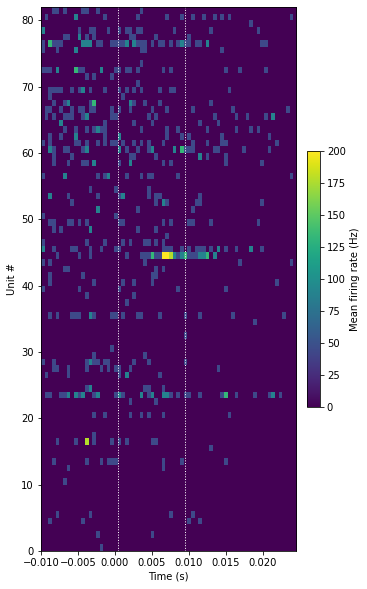

In [56]:
plot_optotagging_response(da)

In [57]:
# Sum spikes across time slice, take mean over trials --> mean firing rate
baseline = da.sel(time_relative_to_stimulus_onset=slice(-0.01,-0.002))
baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001,0.009))
evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

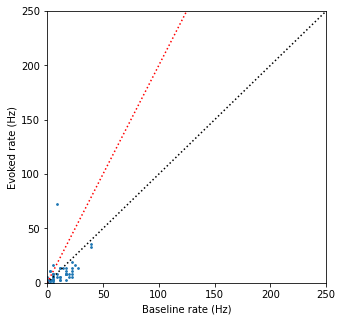

In [58]:
plt.figure(figsize=(5,5))

plt.scatter(baseline_rate, evoked_rate, s=3)

axis_limit = 250
plt.plot([0,axis_limit],[0,axis_limit], ':k')
plt.plot([0,axis_limit],[0,axis_limit*2], ':r')
plt.xlim([0,axis_limit])
plt.ylim([0,axis_limit])

plt.xlabel('Baseline rate (Hz)')
_ = plt.ylabel('Evoked rate (Hz)')

In [59]:
cre_pos_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) > 2].values # add 1 to prevent divide-by-zero errors
cre_pos_units

array([951001485, 951001777, 951002222, 951002348, 951002333, 951002295,
       951002529, 951003999, 951002943], dtype=int64)

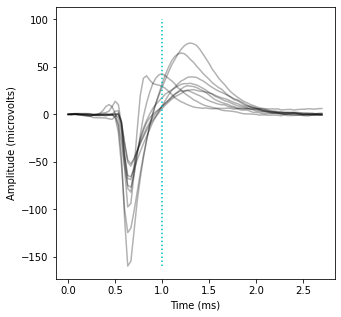

In [60]:
plt.figure(figsize=(5,5))

for unit_id in cre_pos_units:
    
    # Locate peak channel for unit, extract waveform data, plot
    peak_channel = session.units.loc[unit_id].peak_channel_id
    wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel)
    
    plt.plot(wv.time * 1000, wv, 'k', alpha=0.3)

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (microvolts)')
_ =plt.plot([1.0, 1.0],[-160, 100],':c')

## Compute Cell Type Features

In [61]:
# Goals:

# - Find number and proportion of responsive units to opto stimuli (and by how much)
# - Based on waveform characteristics of Excitatory v Inhibitory, classify each unit
# - Final unit dataframe for each session with relevant features

In [62]:
# Get relevant units, keep waveform stats, compute optogenetic response (all 10 ms pulses for now)

In [75]:
# Define function to compute baseline and evoked rate for all units in a session, across all trials, for a particular stim

def calc_optotagging_response(session, stimulus_params, region, raster_plot=False, scatter_plot=False):
    
    duration = stimulus_params.get('duration') # Must be provided
    level = stimulus_params.get('level', None)
    name = stimulus_params.get('stimulus_name', None)
    
    # Select trials
    trials = session.optogenetic_stimulation_epochs[(session.optogenetic_stimulation_epochs.duration > duration - 0.001) & \
                                                    (session.optogenetic_stimulation_epochs.duration < duration + 0.001)]
    if level is not None:
        trials = trials[(trials['level'] == level)]
    if name is not None:
        trials = trials[(trials['stimulus_name'] == name)]
    
    # Select units of interest
    units = session.units[session.units['ecephys_structure_acronym'] == region]

    # Set bin surrounding stimulus params
    time_resolution = 0.0005 # 0.5 ms bins
    bin_edges = np.arange(-duration, duration*2.5, time_resolution) # observe 1*duration before stim and 2.5*duration after

    da = optotagging_spike_counts(bin_edges, trials, units)
    
    if raster_plot:
        plot_optotagging_response(da)
    
    # Section data based on time relative to stimulus onset and compute firing rates
    baseline = da.sel(time_relative_to_stimulus_onset=slice(-duration,-0.002))
    baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset') / (duration-0.002)
    
    evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001, duration - 0.001))
    evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset') / (duration-0.002)
    
    if scatter_plot:
        
        plt.figure(figsize=(5,5))

        plt.scatter(baseline_rate.mean(dim='trial_id'), evoked_rate.mean(dim='trial_id'), s=3)

        axis_limit = 250
        plt.plot([0,axis_limit],[0,axis_limit], ':k')
        plt.plot([0,axis_limit],[0,axis_limit*2], ':r') # 2*baseline response
        plt.xlim([0,axis_limit])
        plt.ylim([0,axis_limit])

        plt.xlabel('Baseline rate (Hz)')
        _ = plt.ylabel('Evoked rate (Hz)')
        
    return da.unit_id, baseline_rate, evoked_rate

Positive Units: [951001485 951001777 951002222 951002348 951002333 951002295 951002529
 951003999 951002943]


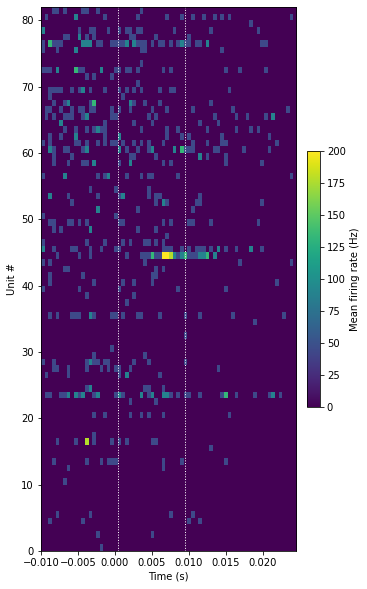

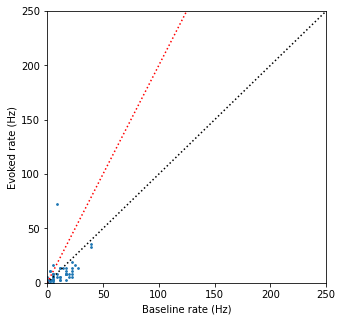

In [77]:
# Example
stimulus_params = {'duration': 0.01}
units, baseline_rate, evoked_rate = calc_optotagging_response(session, stimulus_params, 'VISp', raster_plot=True, scatter_plot=True)
print(f"Positive Units: {units[(evoked_rate.mean(dim='trial_id') / (baseline_rate.mean(dim='trial_id') + 1)) > 2].values}") # +1 zerodivisionerror can be better

In [89]:
# Calculate for all sessions

unit_dfs = []
stimulus_params = {'duration': 0.01}
region = 'VISp'

for session_id in functional_connectivity_sessions.index:
    print(f'Computing Session: \t {session_id}')
    
    session = cache.get_session_data(session_id)
    
    _, baseline_rate, evoked_rate = calc_optotagging_response(session, stimulus_params, region, raster_plot=False, scatter_plot=False)
    
    units = session.units[session.units['ecephys_structure_acronym'] == region][['ecephys_structure_acronym']].reset_index()
    
    units['genotype'] = session.full_genotype
    units['trial_id'] = [range(baseline_rate.shape[0])]*units.shape[0]
    units['opto_baseline_rate'], units['opto_evoked_rate'] = [list(x) for x in np.swapaxes(baseline_rate.values,0,1)], [list(x) for x in np.swapaxes(evoked_rate.values,0,1)]
    
    unit_dfs.append(units)

all_units_df = pd.concat(unit_dfs).explode(['opto_baseline_rate', 'opto_evoked_rate', 'trial_id']).reset_index(drop=True)

Computing Session: 	 766640955
Computing Session: 	 767871931
Computing Session: 	 768515987
Computing Session: 	 771160300
Computing Session: 	 771990200


C:\Users\User\.conda\envs\py37\lib\site-packages\allensdk\brain_observatory\ecephys\ecephys_session.py:1348: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


Computing Session: 	 774875821
Computing Session: 	 778240327
Computing Session: 	 778998620
Computing Session: 	 779839471
Computing Session: 	 781842082
Computing Session: 	 786091066
Computing Session: 	 787025148
Computing Session: 	 789848216
Computing Session: 	 793224716
Computing Session: 	 794812542
Computing Session: 	 816200189
Computing Session: 	 819186360
Computing Session: 	 819701982
Computing Session: 	 821695405
Computing Session: 	 829720705
Computing Session: 	 831882777
Computing Session: 	 835479236
Computing Session: 	 839068429
Computing Session: 	 839557629
Computing Session: 	 840012044
Computing Session: 	 847657808


In [90]:
all_units_df.to_csv('G:/Shared drives/visual_encoding/data/results/opto_units.csv', index=False)
# all_units_df = pd.read_csv('G:/Shared drives/visual_encoding/data/results/opto_units.csv')
all_units_df

,index,unit_id,ecephys_structure_acronym,genotype,trial_id,opto_baseline_rate,opto_evoked_rate
0,0,950929283,VISp,wt/wt,0,0.0,0.0
1,0,950929283,VISp,wt/wt,1,0.0,0.0
2,0,950929283,VISp,wt/wt,2,0.0,0.0
3,0,950929283,VISp,wt/wt,3,0.0,0.0
4,0,950929283,VISp,wt/wt,4,0.0,0.0
...,...,...,...,...,...,...,...
105236,49,951187369,VISp,wt/wt,70,0.0,0.0
105237,49,951187369,VISp,wt/wt,71,0.0,0.0
105238,49,951187369,VISp,wt/wt,72,0.0,0.0
105239,49,951187369,VISp,wt/wt,73,0.0,0.0


Code below does not work without averaging across trials

In [55]:
all_units_df['genotype'].value_counts()

wt/wt                                              966
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      422
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    151
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      140
Name: genotype, dtype: int64

In [56]:
all_units_df['evoked_baseline_ratio'] = all_units_df['opto_evoked_rate']/all_units_df['opto_baseline_rate']
np.isinf(all_units_df['evoked_baseline_ratio']).sum()

165

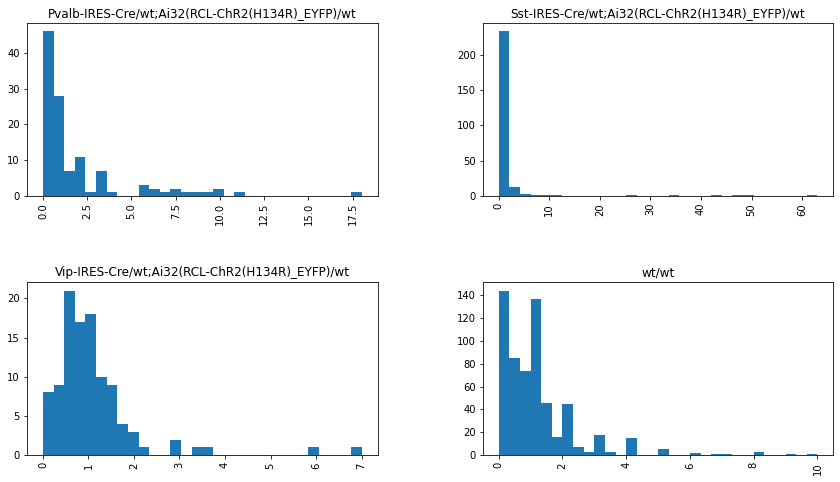

In [57]:
# drop inf ratios for now
all_units_df = all_units_df[~np.isinf(all_units_df['evoked_baseline_ratio'])]
all_units_df.dropna().hist('evoked_baseline_ratio', by='genotype', figsize=(14, 8), bins=30);